In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/My Drive/EVA5/Week10/")

In [3]:
!pip install -U git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-r0actjvv
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-r0actjvv
     |████████████████████████████████| 952kB 4.7MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=69177 sha256=8b5bbd518a10a4eb66b5185ede0b9b7e7a273a51316cd64a998a779efea7bf8c
  Stored in directory: /tmp/pip-ephem-wheel-cache-y3fwse51/wheels/6f/77/82/86baf8aeda64a6de0f890cd0f2fb31acaf5545cc9c99ad21ba
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [4]:
!pip install torch-lr-finder

In [24]:
import time
import torch
!pip install torchsummary
from data.data_loaders.base_data_loader import BaseDataLoader
from data.base_data_utils import get_data_loaders
from utils.misc_utils import get_device_type, current_config
from models.networks.resnet_Session9 import ResNet18
from models.networks.resnet_session9_lr_finder import ResNet18 as ResNet18_lrf
from configs import basic_config
from utils.visualization_utils import plot_multigraph, plot_misclassified_images, plot_LR_graph
from models.model_builder import build_model
from utils import logger_utils
from orchestrators.base_orchestrator import start_training
from orchestrators.base_orchestrator import display_classwise_accuracy
from torchsummary import summary
from torchvision.utils import make_grid, save_image
from models.gradcam.utils import visualize_cam
from models.gradcam.gradcam import GradCAM
from data.base_data_utils import sample_data
from models.learning_rates import lr_finder

from data.data_transforms.base_data_transforms import UnNormalize

from models.gradcam.gen_gradcam import generate_grad_cam_grid,generate_missclassified_gradcam_grid
import warnings
warnings.filterwarnings('ignore')

In [6]:
current_config()

EPOCHS - 50
SEED - 1
agumentation_package - Albumentation
cuda - True
data - {'img_augs': {'rotate': {'rotate_limit': [-7, 7]}, 'cutout': {'num_holes': 1, 'max_h_size': 16, 'max_w_size': 16, 'fill_value': (0.4914, 0.4822, 0.4465), 'always_apply': False, 'p': 0.5}, 'RandomSizedCrop': {'height': 32, 'width': 32, 'min_max_height': [28, 28]}, 'HorizontalFlip': {}}, 'normalize_paras': [(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.201)], 'dataloader_args': {'shuffle': True, 'batch_size': 128, 'num_workers': 4, 'pin_memory': True}, 'data_kind': {'dataset_type': 'open_datasets', 'dataset_name': 'CIFAR10', 'datasets_location': 'data/datasets'}}
l1_lambda - 0.0
logger_config - {'log_filename': 'logs/Session10_assignment', 'level': 20, 'format': '%(asctime)s %(levelname)-8s [%(filename)s:%(lineno)d] %(message)s', 'datefmt': '%d-%m-%Y:%H:%M:%S'}
lr_scheduler - {'use_scheduler': True, 'ReduceLROnPlateau': {'mode': 'min', 'factor': 0.2, 'patience': 5, 'threshold': 0.0001, 'threshold_mode': 'rel', 'c

In [7]:
logger = logger_utils.get_logger(__name__)

In [8]:
train_loader, test_loader = get_data_loaders(dataset_name='cifar10')


**** Started Loading data ****

Files already downloaded and verified
CUDA Available? True
Files already downloaded and verified
CUDA Available? True
CUDA Available? True

**** Ended Loading data ****



In [9]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

plane   dog  frog  bird


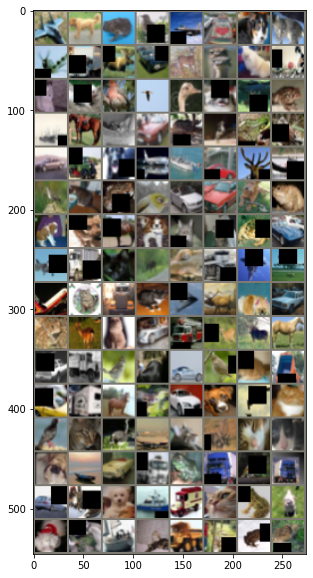

In [10]:
sample_data(train_loader, classes)

In [11]:
def print_summary(network,title):
  print(title)
  summary(network,input_size=(3,32,32))

In [12]:
device = get_device_type()
model = ResNet18().to(device)
print_summary(model,'Network summary')

Network summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14   

In [13]:
model_temp = ResNet18_lrf().to(device)
print_summary(model,'Network summary of model with only softmax (not log softmax as lr_finder uses crossentropy loss)')

Network summary of model with only softmax (not log softmax as lr_finder uses crossentropy loss)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
      


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.00E-01


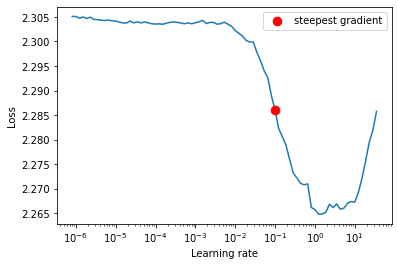

'\nWhen we ran lr_finder for multiple times we got below suggested best LRs\n\n1.52E-01\n1.00E-01\n6.58E-02\n1.00E-01\n1.00E-01\n5.34E-02\n6.58E-02\n2.31E-01\n\nOut of these, we tried frequently suggested LRs 1.00E-01 and 6.58E-02. LR 6.58E-02 gave best results of 90.76% validation acc within 50 epochs.\n'

In [14]:
lr_finder.get_best_lr_sgd(model_temp, train_loader, lr=1e-7, momentum=0.9, end_lr=100, num_iter=100)

"""
When we ran lr_finder for multiple times we got below suggested best LRs

1.52E-01
1.00E-01
6.58E-02
1.00E-01
1.00E-01
5.34E-02
6.58E-02
2.31E-01

Out of these, we tried frequently suggested LRs 1.00E-01 and 6.58E-02. LR 6.58E-02 gave best results of 90.76% validation acc within 50 epochs.
"""

In [15]:
#for i in range(0,10):
#  model_temp = ResNet18_lrf().to(device)
#  lr_finder.get_best_lr_sgd(model_temp, train_loader, lr=1e-7, momentum=0.9, end_lr=100, num_iter=100)

In [16]:
EPOCHS = basic_config.EPOCHS
device = get_device_type()
results = {}

models_dict = {'resnet18': {'model': model}
          }


In [17]:


## Training

results = start_training(EPOCHS, device, train_loader, test_loader, **models_dict)

  0%|          | 0/391 [00:00<?, ?it/s]


**** Started training ****


Model: resnet18

0 0
Optimizer paras: optimizer=sgd, lr=0.0534,momentum=0.9, weight_decay=0.0
LR Scheduler paras: {'mode': 'min', 'factor': 0.2, 'patience': 5, 'threshold': 0.0001, 'threshold_mode': 'rel', 'cooldown': 0, 'min_lr': 0, 'name': 'ReduceLROnPlateau'}
[EPOCH:0]

Current LR: 0.0534



Loss=1.4792959690093994 Batch_id=390 Current_train_batch_accuracy=35.06: 100%|██████████| 391/391 [00:36<00:00, 10.57it/s]



Train set: Average loss: 1.5763, Accuracy: 21087/50000 (42.17%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.5899, Accuracy: 4303/10000 (43.03%)

best_test_accuracy 43.03
[EPOCH:1]

Current LR: 0.0534



Loss=1.0673325061798096 Batch_id=390 Current_train_batch_accuracy=52.17: 100%|██████████| 391/391 [00:37<00:00, 10.55it/s]



Train set: Average loss: 1.2270, Accuracy: 27554/50000 (55.11%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.2166, Accuracy: 5709/10000 (57.09%)

best_test_accuracy 57.09
[EPOCH:2]

Current LR: 0.0534



Loss=1.0633630752563477 Batch_id=390 Current_train_batch_accuracy=61.98: 100%|██████████| 391/391 [00:37<00:00, 10.51it/s]



Train set: Average loss: 0.9699, Accuracy: 32796/50000 (65.59%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.0165, Accuracy: 6519/10000 (65.19%)

best_test_accuracy 65.19
[EPOCH:3]

Current LR: 0.0534



Loss=0.9294062852859497 Batch_id=390 Current_train_batch_accuracy=68.01: 100%|██████████| 391/391 [00:36<00:00, 10.57it/s]



Train set: Average loss: 0.9066, Accuracy: 34326/50000 (68.65%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.1462, Accuracy: 6412/10000 (64.12%)

best_test_accuracy 65.19
[EPOCH:4]

Current LR: 0.0534



Loss=0.9199949502944946 Batch_id=390 Current_train_batch_accuracy=72.00: 100%|██████████| 391/391 [00:37<00:00, 10.50it/s]



Train set: Average loss: 0.8379, Accuracy: 35263/50000 (70.53%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7651, Accuracy: 7411/10000 (74.11%)

best_test_accuracy 74.11
[EPOCH:5]

Current LR: 0.0534



Loss=0.6287823915481567 Batch_id=390 Current_train_batch_accuracy=75.42: 100%|██████████| 391/391 [00:37<00:00, 10.54it/s]



Train set: Average loss: 0.6672, Accuracy: 38202/50000 (76.40%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6848, Accuracy: 7655/10000 (76.55%)

best_test_accuracy 76.55
[EPOCH:6]

Current LR: 0.0534



Loss=0.601678729057312 Batch_id=390 Current_train_batch_accuracy=77.38: 100%|██████████| 391/391 [00:37<00:00, 10.54it/s]



Train set: Average loss: 0.5974, Accuracy: 39584/50000 (79.17%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6364, Accuracy: 7827/10000 (78.27%)

best_test_accuracy 78.27
[EPOCH:7]

Current LR: 0.0534



Loss=0.4310533404350281 Batch_id=390 Current_train_batch_accuracy=79.18: 100%|██████████| 391/391 [00:36<00:00, 10.58it/s]



Train set: Average loss: 0.6116, Accuracy: 39304/50000 (78.61%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7193, Accuracy: 7642/10000 (76.42%)

best_test_accuracy 78.27
[EPOCH:8]

Current LR: 0.0534



Loss=0.7716602087020874 Batch_id=390 Current_train_batch_accuracy=80.80: 100%|██████████| 391/391 [00:37<00:00, 10.53it/s]



Train set: Average loss: 0.5206, Accuracy: 40966/50000 (81.93%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5699, Accuracy: 8111/10000 (81.11%)

best_test_accuracy 81.11
[EPOCH:9]

Current LR: 0.0534



Loss=0.5029875040054321 Batch_id=390 Current_train_batch_accuracy=81.99: 100%|██████████| 391/391 [00:37<00:00, 10.52it/s]



Train set: Average loss: 0.5390, Accuracy: 40391/50000 (80.78%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5452, Accuracy: 8124/10000 (81.24%)

best_test_accuracy 81.24
[EPOCH:10]

Current LR: 0.0534



Loss=0.3166753649711609 Batch_id=390 Current_train_batch_accuracy=82.99: 100%|██████████| 391/391 [00:37<00:00, 10.55it/s]



Train set: Average loss: 0.4430, Accuracy: 42223/50000 (84.45%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4832, Accuracy: 8410/10000 (84.10%)

best_test_accuracy 84.1
[EPOCH:11]

Current LR: 0.0534



Loss=0.40044793486595154 Batch_id=390 Current_train_batch_accuracy=84.20: 100%|██████████| 391/391 [00:37<00:00, 10.55it/s]



Train set: Average loss: 0.4410, Accuracy: 42159/50000 (84.32%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5155, Accuracy: 8296/10000 (82.96%)

best_test_accuracy 84.1
[EPOCH:12]

Current LR: 0.0534



Loss=0.5221137404441833 Batch_id=390 Current_train_batch_accuracy=85.10: 100%|██████████| 391/391 [00:37<00:00, 10.52it/s]



Train set: Average loss: 0.4290, Accuracy: 42477/50000 (84.95%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4755, Accuracy: 8433/10000 (84.33%)

best_test_accuracy 84.33
[EPOCH:13]

Current LR: 0.0534



Loss=0.4279119074344635 Batch_id=390 Current_train_batch_accuracy=85.51: 100%|██████████| 391/391 [00:37<00:00, 10.54it/s]



Train set: Average loss: 0.3952, Accuracy: 43120/50000 (86.24%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5370, Accuracy: 8293/10000 (82.93%)

best_test_accuracy 84.33
[EPOCH:14]

Current LR: 0.0534



Loss=0.2527042031288147 Batch_id=390 Current_train_batch_accuracy=86.40: 100%|██████████| 391/391 [00:36<00:00, 10.57it/s]



Train set: Average loss: 0.3721, Accuracy: 43416/50000 (86.83%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5250, Accuracy: 8301/10000 (83.01%)

best_test_accuracy 84.33
[EPOCH:15]

Current LR: 0.0534



Loss=0.607516884803772 Batch_id=390 Current_train_batch_accuracy=86.89: 100%|██████████| 391/391 [00:36<00:00, 10.59it/s]



Train set: Average loss: 0.3399, Accuracy: 43946/50000 (87.89%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4820, Accuracy: 8455/10000 (84.55%)

best_test_accuracy 84.55
[EPOCH:16]

Current LR: 0.0534



Loss=0.259025514125824 Batch_id=390 Current_train_batch_accuracy=87.67: 100%|██████████| 391/391 [00:37<00:00, 10.56it/s]



Train set: Average loss: 0.3300, Accuracy: 44168/50000 (88.34%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4903, Accuracy: 8450/10000 (84.50%)

best_test_accuracy 84.55
[EPOCH:17]

Current LR: 0.0534



Loss=0.47328487038612366 Batch_id=390 Current_train_batch_accuracy=88.23: 100%|██████████| 391/391 [00:37<00:00, 10.53it/s]



Train set: Average loss: 0.3019, Accuracy: 44705/50000 (89.41%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4221, Accuracy: 8622/10000 (86.22%)

best_test_accuracy 86.22
[EPOCH:18]

Current LR: 0.0534



Loss=0.3327735364437103 Batch_id=390 Current_train_batch_accuracy=88.59: 100%|██████████| 391/391 [00:36<00:00, 10.58it/s]



Train set: Average loss: 0.2982, Accuracy: 44705/50000 (89.41%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4699, Accuracy: 8466/10000 (84.66%)

best_test_accuracy 86.22
[EPOCH:19]

Current LR: 0.0534



Loss=0.22652709484100342 Batch_id=390 Current_train_batch_accuracy=89.20: 100%|██████████| 391/391 [00:36<00:00, 10.57it/s]



Train set: Average loss: 0.2931, Accuracy: 44819/50000 (89.64%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3801, Accuracy: 8770/10000 (87.70%)

best_test_accuracy 87.7
[EPOCH:20]

Current LR: 0.0534



Loss=0.44025135040283203 Batch_id=390 Current_train_batch_accuracy=89.48: 100%|██████████| 391/391 [00:36<00:00, 10.60it/s]



Train set: Average loss: 0.2969, Accuracy: 44722/50000 (89.44%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4159, Accuracy: 8656/10000 (86.56%)

best_test_accuracy 87.7
[EPOCH:21]

Current LR: 0.0534



Loss=0.19971111416816711 Batch_id=390 Current_train_batch_accuracy=89.95: 100%|██████████| 391/391 [00:36<00:00, 10.57it/s]



Train set: Average loss: 0.2796, Accuracy: 45035/50000 (90.07%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4502, Accuracy: 8589/10000 (85.89%)

best_test_accuracy 87.7
[EPOCH:22]

Current LR: 0.0534



Loss=0.37732619047164917 Batch_id=390 Current_train_batch_accuracy=90.51: 100%|██████████| 391/391 [00:37<00:00, 10.53it/s]



Train set: Average loss: 0.2522, Accuracy: 45654/50000 (91.31%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3962, Accuracy: 8738/10000 (87.38%)

best_test_accuracy 87.7
[EPOCH:23]

Current LR: 0.0534



Loss=0.19957378506660461 Batch_id=390 Current_train_batch_accuracy=90.57: 100%|██████████| 391/391 [00:36<00:00, 10.59it/s]



Train set: Average loss: 0.2439, Accuracy: 45701/50000 (91.40%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3635, Accuracy: 8857/10000 (88.57%)

best_test_accuracy 88.57
[EPOCH:24]

Current LR: 0.0534



Loss=0.256341814994812 Batch_id=390 Current_train_batch_accuracy=91.09: 100%|██████████| 391/391 [00:37<00:00, 10.55it/s]



Train set: Average loss: 0.2579, Accuracy: 45394/50000 (90.79%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4414, Accuracy: 8704/10000 (87.04%)

best_test_accuracy 88.57
[EPOCH:25]

Current LR: 0.0534



Loss=0.31257137656211853 Batch_id=390 Current_train_batch_accuracy=91.46: 100%|██████████| 391/391 [00:37<00:00, 10.56it/s]



Train set: Average loss: 0.2292, Accuracy: 45950/50000 (91.90%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3675, Accuracy: 8792/10000 (87.92%)

best_test_accuracy 88.57
[EPOCH:26]

Current LR: 0.0534



Loss=0.3662189543247223 Batch_id=390 Current_train_batch_accuracy=91.72: 100%|██████████| 391/391 [00:37<00:00, 10.50it/s]



Train set: Average loss: 0.2105, Accuracy: 46314/50000 (92.63%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3605, Accuracy: 8872/10000 (88.72%)

best_test_accuracy 88.72
[EPOCH:27]

Current LR: 0.0534



Loss=0.251475989818573 Batch_id=390 Current_train_batch_accuracy=92.01: 100%|██████████| 391/391 [00:37<00:00, 10.52it/s]



Train set: Average loss: 0.2019, Accuracy: 46448/50000 (92.90%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3954, Accuracy: 8805/10000 (88.05%)

best_test_accuracy 88.72
[EPOCH:28]

Current LR: 0.0534



Loss=0.26188069581985474 Batch_id=390 Current_train_batch_accuracy=92.13: 100%|██████████| 391/391 [00:37<00:00, 10.52it/s]



Train set: Average loss: 0.2017, Accuracy: 46455/50000 (92.91%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4296, Accuracy: 8669/10000 (86.69%)

best_test_accuracy 88.72
[EPOCH:29]

Current LR: 0.0534



Loss=0.2961046099662781 Batch_id=390 Current_train_batch_accuracy=92.63: 100%|██████████| 391/391 [00:37<00:00, 10.50it/s]



Train set: Average loss: 0.2174, Accuracy: 46148/50000 (92.30%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4103, Accuracy: 8808/10000 (88.08%)

best_test_accuracy 88.72
[EPOCH:30]

Current LR: 0.0534



Loss=0.17943140864372253 Batch_id=390 Current_train_batch_accuracy=92.86: 100%|██████████| 391/391 [00:37<00:00, 10.48it/s]



Train set: Average loss: 0.1768, Accuracy: 46904/50000 (93.81%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3787, Accuracy: 8887/10000 (88.87%)

best_test_accuracy 88.87
[EPOCH:31]

Current LR: 0.0534



Loss=0.31389325857162476 Batch_id=390 Current_train_batch_accuracy=92.93: 100%|██████████| 391/391 [00:37<00:00, 10.54it/s]



Train set: Average loss: 0.1851, Accuracy: 46720/50000 (93.44%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3877, Accuracy: 8901/10000 (89.01%)

best_test_accuracy 89.01
[EPOCH:32]

Current LR: 0.0534



Loss=0.16599290072917938 Batch_id=390 Current_train_batch_accuracy=93.26: 100%|██████████| 391/391 [00:36<00:00, 10.57it/s]



Train set: Average loss: 0.1695, Accuracy: 46991/50000 (93.98%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3690, Accuracy: 8911/10000 (89.11%)

best_test_accuracy 89.11
[EPOCH:33]

Current LR: 0.010680000000000002



Loss=0.04699476808309555 Batch_id=390 Current_train_batch_accuracy=95.18: 100%|██████████| 391/391 [00:36<00:00, 10.63it/s]



Train set: Average loss: 0.1101, Accuracy: 48086/50000 (96.17%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3438, Accuracy: 9049/10000 (90.49%)

best_test_accuracy 90.49
[EPOCH:34]

Current LR: 0.010680000000000002



Loss=0.12507739663124084 Batch_id=390 Current_train_batch_accuracy=95.70: 100%|██████████| 391/391 [00:37<00:00, 10.55it/s]



Train set: Average loss: 0.0999, Accuracy: 48274/50000 (96.55%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3222, Accuracy: 9087/10000 (90.87%)

best_test_accuracy 90.87
[EPOCH:35]

Current LR: 0.010680000000000002



Loss=0.08506511151790619 Batch_id=390 Current_train_batch_accuracy=95.98: 100%|██████████| 391/391 [00:36<00:00, 10.60it/s]



Train set: Average loss: 0.0985, Accuracy: 48269/50000 (96.54%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3439, Accuracy: 9071/10000 (90.71%)

best_test_accuracy 90.87
[EPOCH:36]

Current LR: 0.010680000000000002



Loss=0.10297451168298721 Batch_id=390 Current_train_batch_accuracy=96.14: 100%|██████████| 391/391 [00:36<00:00, 10.60it/s]



Train set: Average loss: 0.0941, Accuracy: 48350/50000 (96.70%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3273, Accuracy: 9097/10000 (90.97%)

best_test_accuracy 90.97
[EPOCH:37]

Current LR: 0.010680000000000002



Loss=0.08344792574644089 Batch_id=390 Current_train_batch_accuracy=96.45: 100%|██████████| 391/391 [00:36<00:00, 10.57it/s]



Train set: Average loss: 0.0904, Accuracy: 48386/50000 (96.77%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3505, Accuracy: 9055/10000 (90.55%)

best_test_accuracy 90.97
[EPOCH:38]

Current LR: 0.010680000000000002



Loss=0.1172790676355362 Batch_id=390 Current_train_batch_accuracy=96.37: 100%|██████████| 391/391 [00:36<00:00, 10.63it/s]



Train set: Average loss: 0.0906, Accuracy: 48388/50000 (96.78%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3342, Accuracy: 9098/10000 (90.98%)

best_test_accuracy 90.98
[EPOCH:39]

Current LR: 0.010680000000000002



Loss=0.21199914813041687 Batch_id=390 Current_train_batch_accuracy=96.48: 100%|██████████| 391/391 [00:36<00:00, 10.63it/s]



Train set: Average loss: 0.0873, Accuracy: 48498/50000 (97.00%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3415, Accuracy: 9095/10000 (90.95%)

best_test_accuracy 90.98
[EPOCH:40]

Current LR: 0.010680000000000002



Loss=0.1037207841873169 Batch_id=390 Current_train_batch_accuracy=96.71: 100%|██████████| 391/391 [00:36<00:00, 10.64it/s]



Train set: Average loss: 0.0865, Accuracy: 48485/50000 (96.97%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3203, Accuracy: 9140/10000 (91.40%)

best_test_accuracy 91.4
[EPOCH:41]

Current LR: 0.010680000000000002



Loss=0.12583933770656586 Batch_id=390 Current_train_batch_accuracy=96.70: 100%|██████████| 391/391 [00:36<00:00, 10.63it/s]



Train set: Average loss: 0.0821, Accuracy: 48529/50000 (97.06%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3339, Accuracy: 9113/10000 (91.13%)

best_test_accuracy 91.4
[EPOCH:42]

Current LR: 0.010680000000000002



Loss=0.11235527694225311 Batch_id=390 Current_train_batch_accuracy=96.76: 100%|██████████| 391/391 [00:36<00:00, 10.60it/s]



Train set: Average loss: 0.0815, Accuracy: 48561/50000 (97.12%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3388, Accuracy: 9089/10000 (90.89%)

best_test_accuracy 91.4
[EPOCH:43]

Current LR: 0.010680000000000002



Loss=0.11810430139303207 Batch_id=390 Current_train_batch_accuracy=96.94: 100%|██████████| 391/391 [00:36<00:00, 10.60it/s]



Train set: Average loss: 0.0784, Accuracy: 48603/50000 (97.21%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3285, Accuracy: 9152/10000 (91.52%)

best_test_accuracy 91.52
[EPOCH:44]

Current LR: 0.010680000000000002



Loss=0.07862238585948944 Batch_id=390 Current_train_batch_accuracy=96.86: 100%|██████████| 391/391 [00:36<00:00, 10.60it/s]



Train set: Average loss: 0.0765, Accuracy: 48698/50000 (97.40%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3211, Accuracy: 9144/10000 (91.44%)

best_test_accuracy 91.52
[EPOCH:45]

Current LR: 0.010680000000000002



Loss=0.1606525480747223 Batch_id=390 Current_train_batch_accuracy=96.94: 100%|██████████| 391/391 [00:36<00:00, 10.61it/s]



Train set: Average loss: 0.0789, Accuracy: 48601/50000 (97.20%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3521, Accuracy: 9119/10000 (91.19%)

best_test_accuracy 91.52
[EPOCH:46]

Current LR: 0.010680000000000002



Loss=0.07520151138305664 Batch_id=390 Current_train_batch_accuracy=96.97: 100%|██████████| 391/391 [00:36<00:00, 10.58it/s]



Train set: Average loss: 0.0741, Accuracy: 48699/50000 (97.40%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3412, Accuracy: 9139/10000 (91.39%)

best_test_accuracy 91.52
[EPOCH:47]

Current LR: 0.0021360000000000003



Loss=0.048338185995817184 Batch_id=390 Current_train_batch_accuracy=97.17: 100%|██████████| 391/391 [00:36<00:00, 10.58it/s]



Train set: Average loss: 0.0701, Accuracy: 48797/50000 (97.59%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3345, Accuracy: 9158/10000 (91.58%)

best_test_accuracy 91.58
[EPOCH:48]

Current LR: 0.0021360000000000003



Loss=0.09752817451953888 Batch_id=390 Current_train_batch_accuracy=97.44: 100%|██████████| 391/391 [00:36<00:00, 10.64it/s]



Train set: Average loss: 0.0681, Accuracy: 48833/50000 (97.67%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3366, Accuracy: 9159/10000 (91.59%)

best_test_accuracy 91.59
[EPOCH:49]

Current LR: 0.0021360000000000003



Loss=0.05406634882092476 Batch_id=390 Current_train_batch_accuracy=97.23: 100%|██████████| 391/391 [00:37<00:00, 10.56it/s]



Train set: Average loss: 0.0649, Accuracy: 48899/50000 (97.80%)


Test set: Average loss: 0.3337, Accuracy: 9160/10000 (91.60%)

best_test_accuracy 91.6

results : {'resnet18': [[42.174, 55.108, 65.592, 68.652, 70.526, 76.404, 79.168, 78.608, 81.932, 80.782, 84.446, 84.318, 84.954, 86.24, 86.832, 87.892, 88.336, 89.41, 89.41, 89.638, 89.444, 90.07, 91.308, 91.402, 90.788, 91.9, 92.628, 92.896, 92.91, 92.296, 93.808, 93.44, 93.982, 96.172, 96.548, 96.538, 96.7, 96.772, 96.776, 96.996, 96.97, 97.058, 97.122, 97.206, 97.396, 97.202, 97.398, 97.594, 97.666, 97.798], [1.5762893948364258, 1.2270448358154298, 0.9699079800415039, 0.9065858674621582, 0.8379414450073243, 0.6672344407653809, 0.5973532592773437, 0.6115879257965088, 0.5205609188842774, 0.5390103517913818, 0.44295341732025145, 0.44101949111938477, 0.428998729057312, 0.39521014469146726, 0.3720594480895996, 0.3399348266983032, 0.3300314573287964, 0.3019293647003174, 0.29815148761749266, 0.2930785523223877, 0.29691339166641234, 0.279

In [18]:
torch.save(model, f'check_points/Session10_assignment_epochs_{EPOCHS}.h5')

In [19]:
lst_plottingJobs_acc = []
lst_plottingLegends_acc = []
lst_plotting_loss = []
lst_plottingLegends_loss = []
lst_plotting_lr = []
lst_plottingLegends_lr = []

for model_type in results:
  lst_plottingJobs_acc.append(results[model_type][0])
  lst_plottingJobs_acc.append(results[model_type][2])
  
  lst_plottingLegends_acc.append('Training accuracy')
  lst_plottingLegends_acc.append('Validation accuracy')

  lst_plotting_loss.append(results[model_type][1])
  lst_plotting_loss.append(results[model_type][3])

  lst_plottingLegends_loss.append('Training loss')
  lst_plottingLegends_loss.append('Validation loss')

  lst_plotting_lr.append(results[model_type][5])
  lst_plottingLegends_lr.append('Learning Rate')


**** Started Plotting multigraph ****



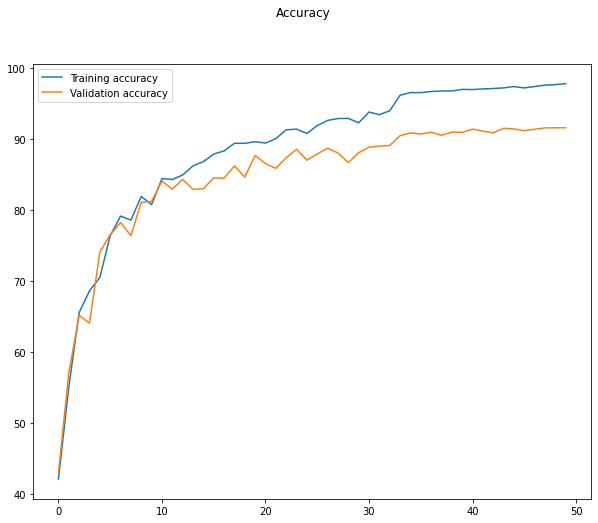


**** Ended Plotting multigraph ****



In [20]:
plot_multigraph(lst_plottingJobs_acc,lst_plottingLegends_acc,title="Accuracy")


**** Started Plotting multigraph ****



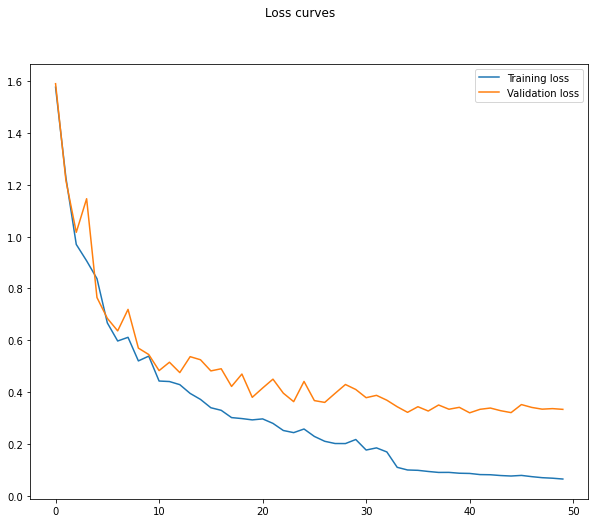


**** Ended Plotting multigraph ****



In [21]:
plot_multigraph(lst_plotting_loss,lst_plottingLegends_loss,title="Loss curves")


**** Started Plotting multigraph ****



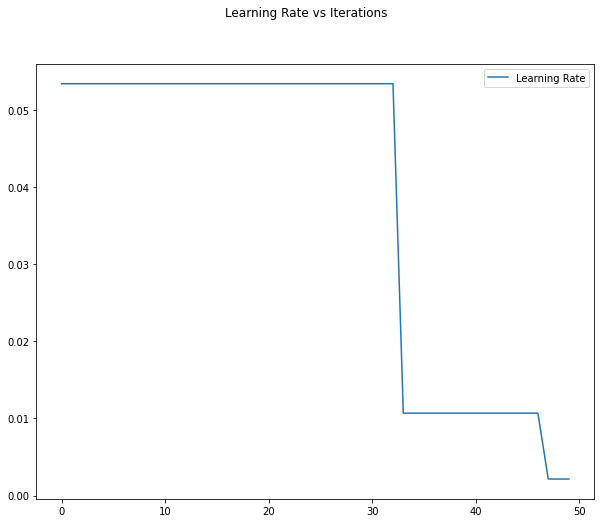


**** Ended Plotting multigraph ****



In [22]:
plot_multigraph(lst_plotting_lr,lst_plottingLegends_lr,title="Learning Rate vs Iterations")


**** Started Plotting Graph ****



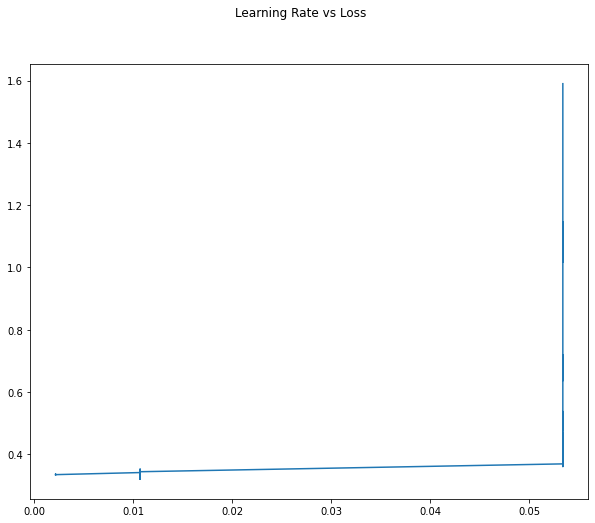


**** Ended Plotting multigraph ****



In [25]:
plot_LR_graph(results[model_type][3],results[model_type][5],'Learning Rate vs Loss')

In [ ]:
#model =torch.load(f'check_points/Session10_assignment_epochs_10.h5')

In [26]:
display_classwise_accuracy(test_loader,device,model,classes)

Accuracy of plane : 96.42857142857143
Accuracy of car : 100.0
Accuracy of bird : 86.66666666666667
Accuracy of cat : 94.28571428571429
Accuracy of deer : 96.7741935483871
Accuracy of dog : 83.33333333333333
Accuracy of frog : 90.3225806451613
Accuracy of horse : 97.05882352941177
Accuracy of ship : 97.29729729729729
Accuracy of truck : 87.5


In [27]:
configs = [dict(model_type='resnet', arch=model, layer_name='layer4')]

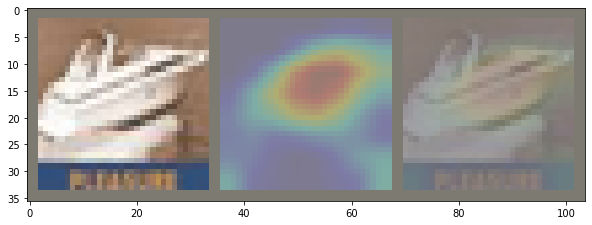

Prediction: bird, Actual: dog


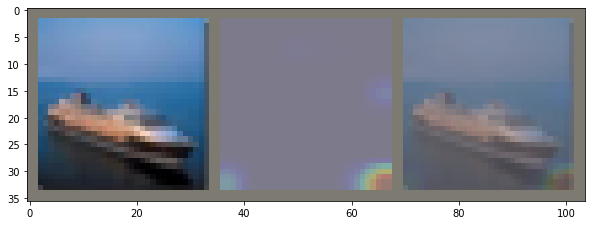

Prediction: dog, Actual: cat


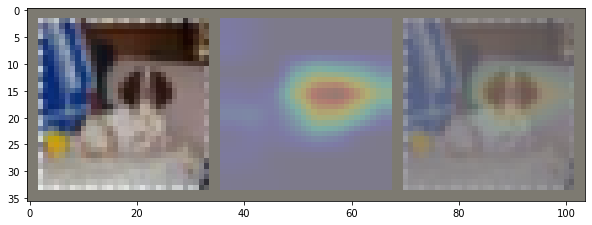

Prediction: dog, Actual: cat


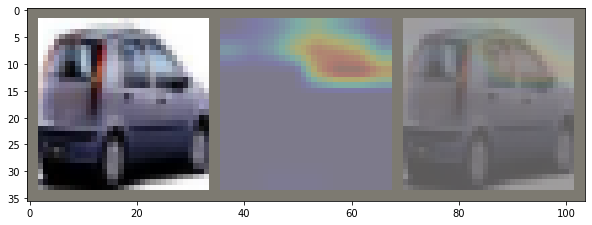

Prediction: cat, Actual: horse


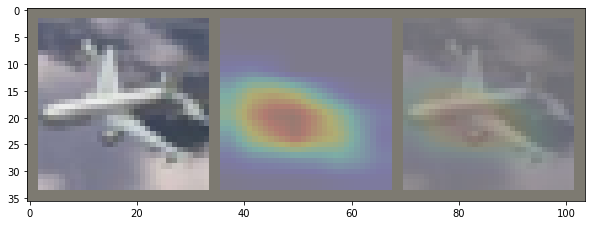

Prediction: plane, Actual: cat


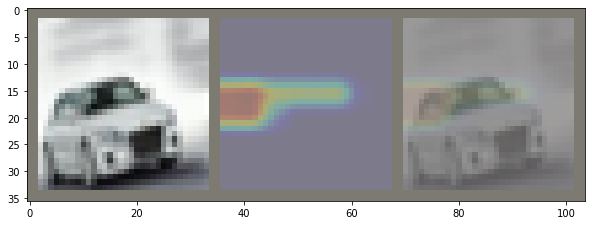

Prediction: deer, Actual: bird


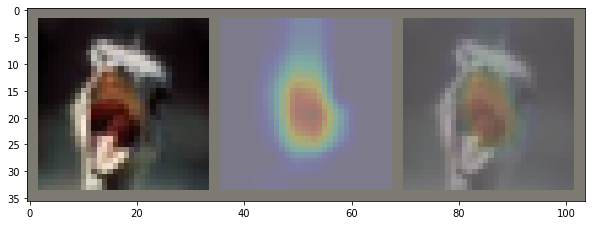

Prediction: horse, Actual: bird


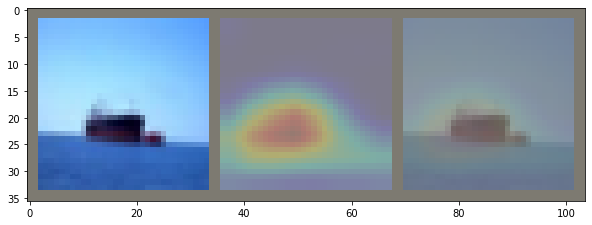

Prediction: cat, Actual: frog


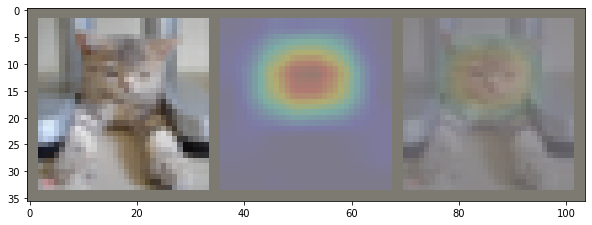

Prediction: plane, Actual: ship


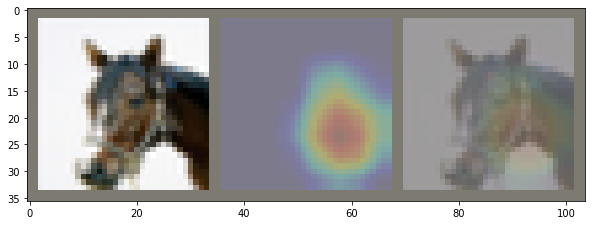

Prediction: plane, Actual: ship


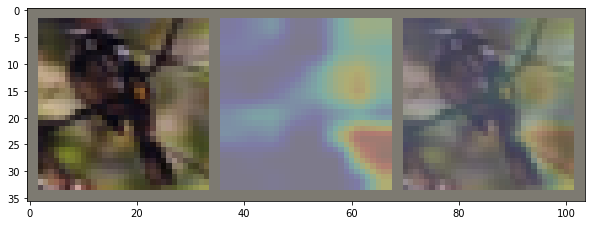

Prediction: cat, Actual: bird


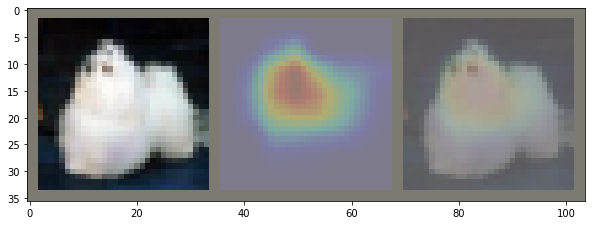

Prediction: bird, Actual: horse


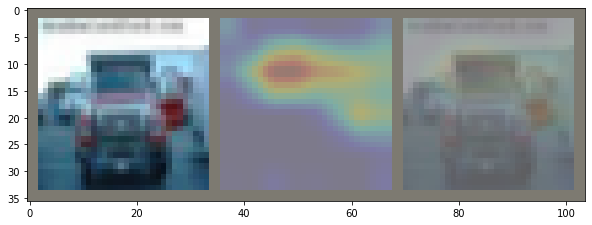

Prediction: frog, Actual: deer


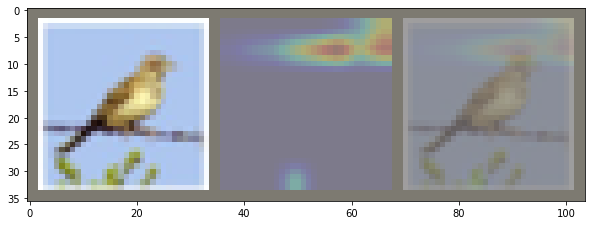

Prediction: frog, Actual: deer


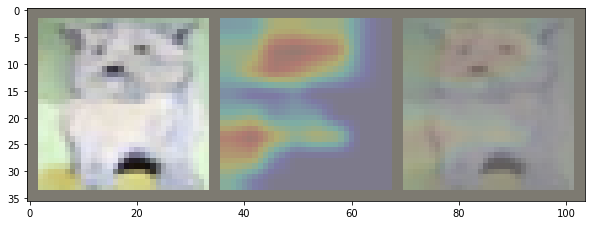

Prediction: deer, Actual: dog


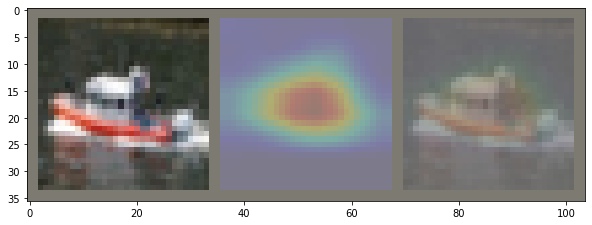

Prediction: frog, Actual: deer


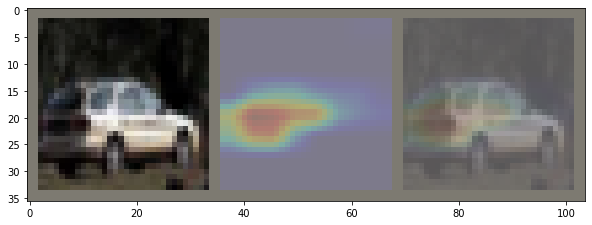

Prediction: cat, Actual: dog


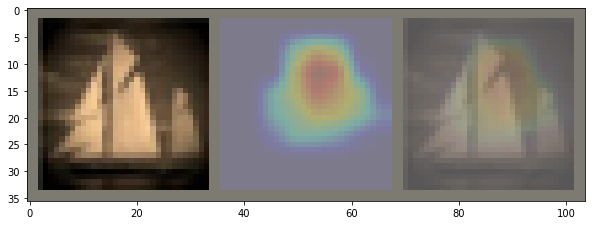

Prediction: truck, Actual: ship


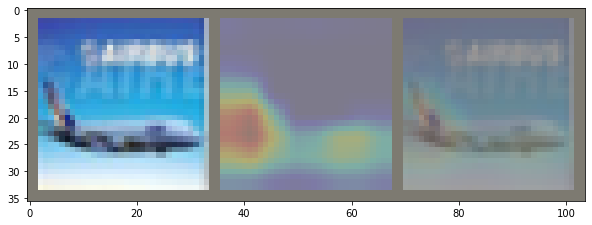

Prediction: plane, Actual: deer


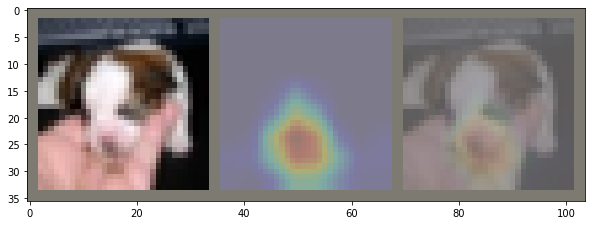

Prediction: bird, Actual: deer


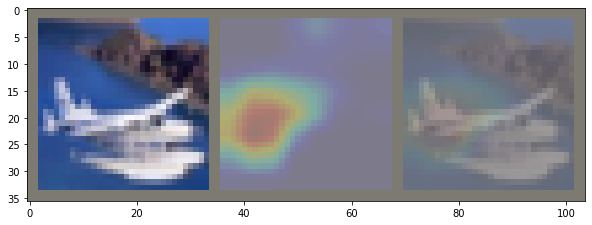

Prediction: cat, Actual: horse


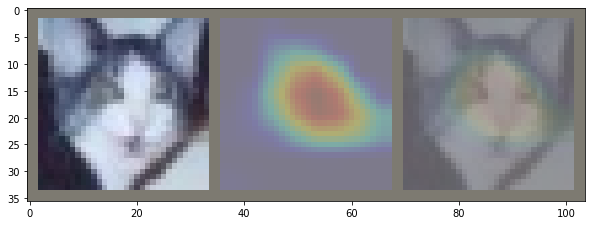

Prediction: frog, Actual: bird


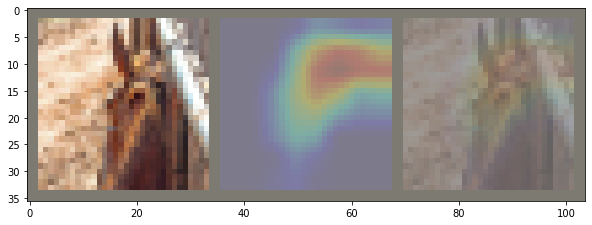

Prediction: deer, Actual: horse


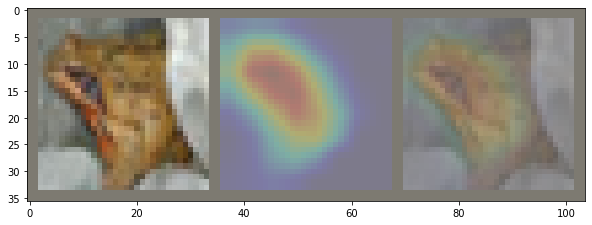

Prediction: car, Actual: ship


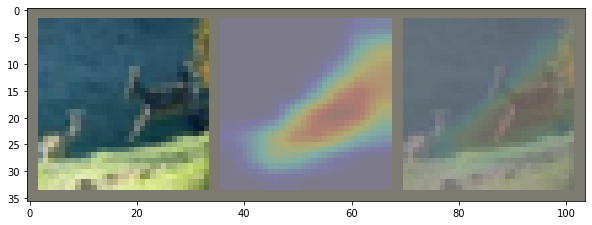

Prediction: plane, Actual: deer


In [28]:
## Misclassified images, but we observed mislabled images as well.
generate_grad_cam_grid(configs, classes, test_loader, device, model, matched=False, num_img=25)

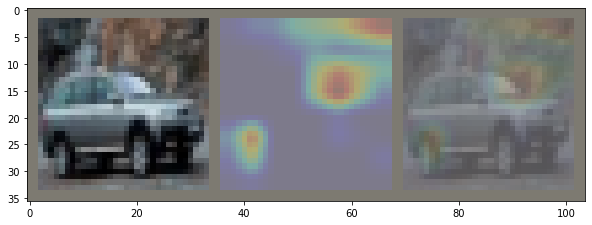

Prediction: car, Actual: car


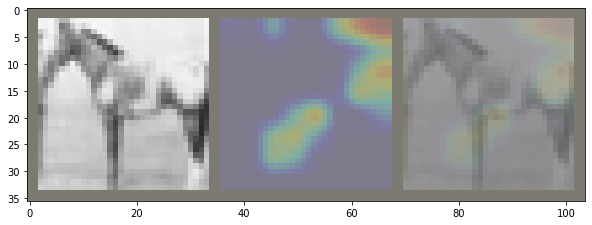

Prediction: horse, Actual: horse


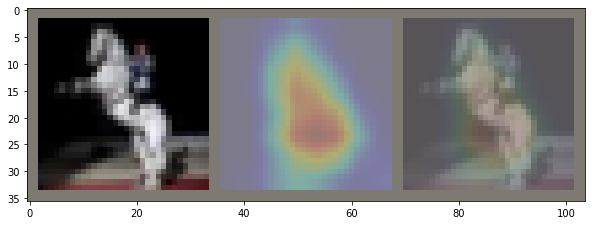

Prediction: horse, Actual: horse


In [29]:
## Correctly classsified images
generate_grad_cam_grid(configs, classes, test_loader, device, model, matched=True, num_img=3)

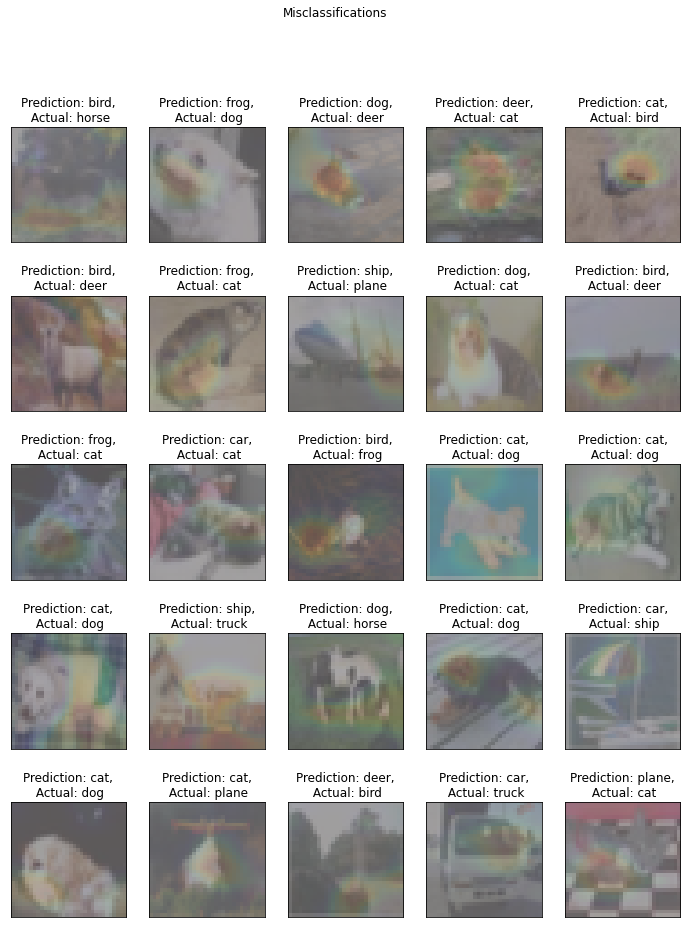

In [30]:
generate_missclassified_gradcam_grid(configs, classes, test_loader, device, model, matched=True, num_of_images=25)